In [1]:
from google.colab import drive
drive.mount('/content/drive')

# Clone GitHub repository
!git clone https://github.com/Amirtalebi83/GNN-OptimalPowerFlow.git
%cd GNN-OptimalPowerFlow

!ls

Mounted at /content/drive
Cloning into 'GNN-OptimalPowerFlow'...
remote: Enumerating objects: 283, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 283 (delta 8), reused 6 (delta 6), pack-reused 273 (from 1)
Receiving objects: 100% (283/283), 260.31 MiB | 40.50 MiB/s, done.
Resolving deltas: 100% (42/42), done.
/content/GNN-OptimalPowerFlow
 Datasets   document  'jupyter notebook'   README.md


In [2]:
# Install PyTorch and PyTorch Geometric
!pip install torch
!pip install torch-geometric
!pip install pandas openpyxl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.7 MB/s eta 0:00:00


In [139]:
!git reset --hard HEAD #Reset Any Local Changes
!git pull origin main #Pull the Latest Changes from GitHub

From https://github.com/Amirtalebi83/GNN-OptimalPowerFlow
 * branch            main       -> FETCH_HEAD
Already up to date.


In [126]:
%cd /content #Remove the local folder and cloning the repository again
!rm -rf GNN-OptimalPowerFlow

In [133]:
!rm -rf GNN-OptimalPowerFlow

In [127]:
!git clone https://github.com/Amirtalebi83/GNN-OptimalPowerFlow.git
!ls -la GNN-OptimalPowerFlow

Cloning into 'GNN-OptimalPowerFlow'...
remote: Enumerating objects: 283, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 283 (delta 8), reused 6 (delta 6), pack-reused 273 (from 1)
Receiving objects: 100% (283/283), 260.31 MiB | 31.53 MiB/s, done.
Resolving deltas: 100% (42/42), done.
Updating files: 100% (54/54), done.
total 36
drwxr-xr-x 6 root root  4096 Nov 14 23:19  .
drwxr-xr-x 7 root root  4096 Nov 14 23:19  ..
drwxr-xr-x 5 root root  4096 Nov 14 23:19  Datasets
drwxr-xr-x 2 root root  4096 Nov 14 23:19  document
drwxr-xr-x 8 root root  4096 Nov 14 23:19  .git
drwxr-xr-x 2 root root  4096 Nov 14 23:19 'jupyter notebook'
-rw-r--r-- 1 root root 10321 Nov 14 23:19  README.md


# **Import Libraries**





In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Linear
import torch_geometric.nn as pyg_nn
from torch_geometric.nn import GCNConv, GraphConv, SAGEConv, GATConv, ChebConv
from torch_geometric.data import Data, DataLoader

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Set print options for better readability
np.set_printoptions(precision=5, suppress=True)
torch.set_printoptions(precision=5, sci_mode=False)


In [4]:
!pip install pandapower

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 35.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 4.9 MB/s eta 0:00:00
  Created wheel for pandapower: filename=pandapower-2.14.11-py3-none-any.whl size=13131028 sha256=25193508472e367355ef7a2e1c605f1cb11d40109ca7aab3743f0a537b7c905b
  Stored in directory: /root/.cache/pip/wheels/7f/de/5a/7b00f385eb06d1fb1f7c1cd06f9bb901709c038d3899548cf1
Successfully built pandapower


# **Dataset Preparation**

In [5]:
import pandapower as pp
import pandapower.networks as nw
import torch
import pandas as pd
from torch_geometric.data import Data, DataLoader

In [6]:
from operator import is_
def slice_dataset(dataset, percentage):
    data_size = len(dataset)
    return dataset[:int(data_size * percentage / 100)]

def make_dataset(dataset, n_bus):
    x_raw, y_raw = [], []

    for i in range(len(dataset)):
        x_sample, y_sample = [], []
        for n in range(n_bus):
            # Define bus type: Slack (1), PQ (2), PV (3)
            is_pv = 0
            is_pq = 0
            is_slack = 0
            if n == 0:  # Slack bus is always bus 0
                is_slack = 1
            elif dataset[i, 4 * n + 2] == 0:  # Q = 0 indicates PV bus
                is_pv = 1
            else:
                is_pq = 1  # PQ bus

            # Include P, Q, V, delta, and bus type as features
            x_sample.append([
                dataset[i, 4 * n + 1],  # P
                dataset[i, 4 * n + 2],  # Q
                dataset[i, 4 * n + 3],  # V
                dataset[i, 4 * n + 4],  # delta
                is_pv,                # Bus type
                is_pq,
                is_slack
            ])

            # Use P and Q as targets
            y_sample.append([
                # dataset[i, 4 * n + 1],  # P (target)
                # dataset[i, 4 * n + 2],   # Q (target)
                dataset[i, 4 * n + 3],   # V (target)
                dataset[i, 4 * n + 4]   # D (target)
            ])

        x_raw.append(x_sample)
        y_raw.append(y_sample)

    # Convert to PyTorch tensors
    x_raw = torch.tensor(x_raw, dtype=torch.float)
    y_raw = torch.tensor(y_raw, dtype=torch.float)
    return x_raw, y_raw


In [7]:
def normalize_dataset(x, y):
    # Compute mean and standard deviation for features and targets
    x_mean, x_std = torch.mean(x, 0), torch.std(x, 0)
    y_mean, y_std = torch.mean(y, 0), torch.std(y, 0)

    # Handle zero standard deviation to avoid division by zero
    x_std[x_std == 0] = 1
    y_std[y_std == 0] = 1

    # Normalize the input features except for the bus type, Bus type should not be normalized as it is (1, 2, or 3)
    x_norm = (x - x_mean) / x_std
    x_norm[:, :, 4] = x[:, :, 4]

    # Normalize the targets
    y_norm = (y - y_mean) / y_std

    return x_norm, y_norm, x_mean, y_mean, x_std, y_std

def denormalize_output(y_norm, y_mean, y_std):
    return y_norm * y_std + y_mean

def MSE(yhat, y):
    return torch.mean((yhat - y) ** 2)


# **Load Dataset**

# **14 Bus Only**

In [75]:
import pandapower as pp
import pandapower.networks as nw
import torch
import pandas as pd
from torch_geometric.data import Data, DataLoader

# Load dataset from Excel files
dataset1 = pd.read_excel('/content/GNN-OptimalPowerFlow/Datasets/14Bus/PF_Dataset_1.xlsx').values
dataset2 = pd.read_excel('/content/GNN-OptimalPowerFlow/Datasets/14Bus/PF_Dataset_2.xlsx').values

# Split the dataset
train_percentage = 100
val_percentage = 100

train_dataset = slice_dataset(dataset1, train_percentage)
val_dataset = slice_dataset(dataset2, val_percentage)

n_bus = 14

# # Prepare training and validation data
x_raw_train, y_raw_train = make_dataset(train_dataset, n_bus)
x_raw_val, y_raw_val = make_dataset(val_dataset, n_bus)

# Normalize the raw data
x_norm_train, y_norm_train, x_train_mean, y_train_mean, x_train_std, y_train_std = normalize_dataset(x_raw_train, y_raw_train)
x_norm_val, y_norm_val, x_val_mean, y_val_mean, x_val_std, y_val_std = normalize_dataset(x_raw_val, y_raw_val)

# Prepare DataLoader for PyTorch Geometric
# Load the IEEE 14-bus test case using pandapower
net = nw.case14()

# Get the 'from_bus' and 'to_bus' for each line in the network
from_buses = net.line['from_bus'].values
to_buses = net.line['to_bus'].values

# Construct the edge index (bidirectional edges)
edge_index = torch.tensor([list(from_buses) + list(to_buses), list(to_buses) + list(from_buses)], dtype=torch.long)

print("Edge Index for IEEE 14-bus System:")
print(edge_index)

# Create Data objects for PyTorch Geometric
train_data_list = [Data(x=x, y=y, edge_index=edge_index) for x, y in zip(x_norm_train, y_norm_train)]
val_data_list = [Data(x=x, y=y, edge_index=edge_index) for x, y in zip(x_norm_val, y_norm_val)]

# Prepare DataLoaders
train_loader = DataLoader(train_data_list, batch_size=16)
val_loader = DataLoader(val_data_list, batch_size=16)

print("Data preparation completed successfully.")


Edge Index for IEEE 14-bus System:
tensor([[ 0,  0,  1,  1,  1,  2,  3,  5,  5,  5,  8,  8,  9, 11, 12,  1,  4,  2,
          3,  4,  3,  4, 10, 11, 12,  9, 13, 10, 12, 13],
        [ 1,  4,  2,  3,  4,  3,  4, 10, 11, 12,  9, 13, 10, 12, 13,  0,  0,  1,
          1,  1,  2,  3,  5,  5,  5,  8,  8,  9, 11, 12]])
Data preparation completed successfully.


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


# **30 Bus Only**

1. **Data Preparation:** Load and filter the dataset

2. **Normalization:**
Normalize the data (normalize_dataset)

3. **Filter Constant Features:** Identify and remove constant features

In [26]:
print(y_raw_train.shape)
print(y_norm_train.shape)

print(x_raw_train.shape)
print(x_norm_train.shape)

torch.Size([2000, 57, 2])
torch.Size([2000, 57, 2])
torch.Size([2000, 57, 7])
torch.Size([2000, 57, 7])


In [27]:
import pandapower as pp
import pandapower.networks as nw
import torch
import pandas as pd
from torch_geometric.data import Data, DataLoader

# Load dataset from Excel files
dataset1 = pd.read_excel('/content/GNN-OptimalPowerFlow/Datasets/30Bus/PF_Dataset_1.xlsx').values
dataset2 = pd.read_excel('/content/GNN-OptimalPowerFlow/Datasets/30Bus/PF_Dataset_2.xlsx').values

# Split the dataset
train_percentage = 100
val_percentage = 100

train_dataset = slice_dataset(dataset1, train_percentage)
val_dataset = slice_dataset(dataset2, val_percentage)

n_bus = 30

# Prepare training and validation data
x_raw_train, y_raw_train = make_dataset(train_dataset, n_bus)
x_raw_val, y_raw_val = make_dataset(val_dataset, n_bus)

# Normalize the raw data
x_norm_train, y_norm_train, x_train_mean, y_train_mean, x_train_std, y_train_std = normalize_dataset(x_raw_train, y_raw_train)
x_norm_val, y_norm_val, x_val_mean, y_val_mean, x_val_std, y_val_std = normalize_dataset(x_raw_val, y_raw_val)

# Prepare DataLoader for PyTorch Geometric
# Load the IEEE 30-bus test case using pandapower
net = nw.case30()

# Get the 'from_bus' and 'to_bus' for each line in the network
from_buses = net.line['from_bus'].values
to_buses = net.line['to_bus'].values

# Construct the edge index (bidirectional edges)
edge_index = torch.tensor([list(from_buses) + list(to_buses), list(to_buses) + list(from_buses)], dtype=torch.long)

print("Edge Index for IEEE 30-bus System:")
print(edge_index)

# Create Data objects for PyTorch Geometric
train_data_list = [Data(x=x, y=y, edge_index=edge_index) for x, y in zip(x_norm_train, y_norm_train)]
val_data_list = [Data(x=x, y=y, edge_index=edge_index) for x, y in zip(x_norm_val, y_norm_val)]

# Prepare DataLoaders
train_loader = DataLoader(train_data_list, batch_size=16)
val_loader = DataLoader(val_data_list, batch_size=16)

print("Data preparation completed successfully.")


Edge Index for IEEE 30-bus System:
tensor([[ 0,  0,  1,  2,  1,  1,  3,  4,  5,  5,  5,  5,  8,  8,  3, 11, 11, 11,
         11, 13, 15, 14, 17, 18,  9,  9,  9,  9, 20, 14, 21, 22, 23, 24, 24, 27,
         26, 26, 28,  7,  5,  1,  2,  3,  3,  4,  5,  5,  6,  6,  7,  8,  9, 10,
          9, 11, 12, 13, 14, 15, 14, 16, 17, 18, 19, 19, 16, 20, 21, 21, 22, 23,
         23, 24, 25, 26, 26, 28, 29, 29, 27, 27],
        [ 1,  2,  3,  3,  4,  5,  5,  6,  6,  7,  8,  9, 10,  9, 11, 12, 13, 14,
         15, 14, 16, 17, 18, 19, 19, 16, 20, 21, 21, 22, 23, 23, 24, 25, 26, 26,
         28, 29, 29, 27, 27,  0,  0,  1,  2,  1,  1,  3,  4,  5,  5,  5,  5,  8,
          8,  3, 11, 11, 11, 11, 13, 15, 14, 17, 18,  9,  9,  9,  9, 20, 14, 21,
         22, 23, 24, 24, 27, 26, 26, 28,  7,  5]])
Data preparation completed successfully.


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


# Backup

In [ ]:
#print("x_std_raw:", x_std_raw)
#print("y_std_raw:", y_std_raw)

# print("Number of NaNs in x_norm_train:", torch.isnan(x_norm_train).sum().item())
# print("Number of NaNs in y_norm_train:", torch.isnan(y_norm_train).sum().item())
print(x_raw_train)
print("Standard deviation of features:", x_val_std)
#print("y_val_mean:", y_val_mean)
print("y_val_std:", y_val_std)

#print(f"Number of non-constant input features: {num_filtered_features}")
#print(f"Number of non-constant target features: {num_filtered_targets}")

tensor([[[ 0.00000,  0.00000,  1.00000,  ...,  0.00000,  0.00000,  1.00000],
         [14.40134, 13.22018,  1.00000,  ...,  0.00000,  1.00000,  0.00000],
         [ 2.99126,  1.21511,  0.98492,  ...,  0.00000,  1.00000,  0.00000],
         ...,
         [ 0.00000,  0.00000,  0.97893,  ...,  1.00000,  0.00000,  0.00000],
         [ 2.91809,  0.84565,  0.97803,  ...,  0.00000,  1.00000,  0.00000],
         [12.16662,  1.42966,  0.96580,  ...,  0.00000,  1.00000,  0.00000]],

        [[ 0.00000,  0.00000,  1.00000,  ...,  0.00000,  0.00000,  1.00000],
         [13.52838,  9.30579,  1.00000,  ...,  0.00000,  1.00000,  0.00000],
         [ 1.90479,  0.94073,  0.98512,  ...,  0.00000,  1.00000,  0.00000],
         ...,
         [ 0.00000,  0.00000,  0.97815,  ...,  1.00000,  0.00000,  0.00000],
         [ 1.76046,  0.89814,  0.98310,  ...,  0.00000,  1.00000,  0.00000],
         [ 9.43754,  1.22884,  0.97348,  ...,  0.00000,  1.00000,  0.00000]],

        [[ 0.00000,  0.00000,  1.00000,  ...

# **57 Bus Only**

In [44]:
import pandapower as pp
import pandapower.networks as nw
import torch
import pandas as pd
from torch_geometric.data import Data, DataLoader

# Load dataset from Excel files
dataset1 = pd.read_excel('/content/GNN-OptimalPowerFlow/Datasets/57Bus/PF_Dataset_1.xlsx').values
dataset2 = pd.read_excel('/content/GNN-OptimalPowerFlow/Datasets/57Bus/PF_Dataset_2.xlsx').values

# Split the dataset
train_percentage = 100
val_percentage = 100

train_dataset = slice_dataset(dataset1, train_percentage)
val_dataset = slice_dataset(dataset2, val_percentage)

n_bus = 57

# # Prepare training and validation data
x_raw_train, y_raw_train = make_dataset(train_dataset, n_bus)
x_raw_val, y_raw_val = make_dataset(val_dataset, n_bus)

# Normalize the raw data
x_norm_train, y_norm_train, x_train_mean, y_train_mean, x_train_std, y_train_std = normalize_dataset(x_raw_train, y_raw_train)
x_norm_val, y_norm_val, x_val_mean, y_val_mean, x_val_std, y_val_std = normalize_dataset(x_raw_val, y_raw_val)

# Prepare DataLoader for PyTorch Geometric
# Load the IEEE 57-bus test case using pandapower
net = nw.case57()

# Get the 'from_bus' and 'to_bus' for each line in the network
from_buses = net.line['from_bus'].values
to_buses = net.line['to_bus'].values

# Construct the edge index (bidirectional edges)
edge_index = torch.tensor([list(from_buses) + list(to_buses), list(to_buses) + list(from_buses)], dtype=torch.long)

print("Edge Index for IEEE 57-bus System:")
print(edge_index)

# Create Data objects for PyTorch Geometric
train_data_list = [Data(x=x, y=y, edge_index=edge_index) for x, y in zip(x_norm_train, y_norm_train)]
val_data_list = [Data(x=x, y=y, edge_index=edge_index) for x, y in zip(x_norm_val, y_norm_val)]

# Prepare DataLoaders
train_loader = DataLoader(train_data_list, batch_size=16)
val_loader = DataLoader(val_data_list, batch_size=16)

print("Data preparation completed successfully.")


Edge Index for IEEE 57-bus System:
tensor([[ 0,  1,  2,  3,  3,  5,  5,  7,  8,  8,  8,  8, 12, 12,  0,  0,  0,  2,
          4,  6,  9, 10, 11, 11, 11, 13, 17, 18, 20, 21, 22, 25, 26, 27, 24, 29,
         30, 31, 33, 34, 35, 36, 36, 35, 21, 40, 40, 37, 45, 46, 47, 48, 49, 28,
         51, 52, 53, 43, 55, 55, 56, 37, 37,  1,  2,  3,  4,  5,  6,  7,  8,  9,
         10, 11, 12, 13, 14, 14, 15, 16, 14,  5,  7, 11, 12, 12, 15, 16, 14, 18,
         19, 21, 22, 23, 26, 27, 28, 29, 30, 31, 32, 34, 35, 36, 37, 38, 39, 37,
         41, 42, 43, 46, 47, 48, 49, 50, 51, 52, 53, 54, 44, 40, 41, 55, 48, 47],
        [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 14, 15, 16, 14,
          5,  7, 11, 12, 12, 15, 16, 14, 18, 19, 21, 22, 23, 26, 27, 28, 29, 30,
         31, 32, 34, 35, 36, 37, 38, 39, 37, 41, 42, 43, 46, 47, 48, 49, 50, 51,
         52, 53, 54, 44, 40, 41, 55, 48, 47,  0,  1,  2,  3,  3,  5,  5,  7,  8,
          8,  8,  8, 12, 12,  0,  0,  0,  2,  4,  6,  9, 10, 11, 11, 11, 

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


# **Define Initial GNN Model**

We will use a simple GCN as the first model and later extend it to include other GNN topologies:

In [76]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class My_GNN_Model(nn.Module):
    def __init__(self, in_channels=7, hidden_channels=8, out_channels=2):
        super(My_GNN_Model, self).__init__()
        self.hidden_channels = hidden_channels

        # the GNN layers
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)

        # the output GNN layer for direct prediction
        self.conv_out = GCNConv(hidden_channels, out_channels)

        if out_channels is None:
            out_channels = 2

        self.lin = Linear(hidden_channels * n_bus, out_channels * n_bus)


    def forward(self, data):


        x, edge_index = data.x, data.edge_index

        # GCN layers with ReLU activation
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))

        # Reshape x for the Linear layer
        batch_size = data.num_graphs  # be 8
        x = x.view(batch_size, n_bus * self.hidden_channels)

        # Apply the output Linear layer
        x = self.lin(x)

        # Reshape to get the final output shape
        return x.view(batch_size * n_bus, 2)


# Initialize the model
model = My_GNN_Model(in_channels=7, out_channels=2)


# **Batch Size=1:**

In [18]:
"""
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class My_GNN_Model(nn.Module):
    def __init__(self, in_channels=7, hidden_channels=8, out_channels=2):
        super(My_GNN_Model, self).__init__()
        # Define the GNN layers
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)

        # Define the output GNN layer for direct prediction
        self.conv_out = GCNConv(hidden_channels, out_channels)

        if out_channels is None:
            out_channels = 2

        self.lin = Linear(hidden_channels * n_bus, out_channels * n_bus)


    def forward(self, data):
        '''
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))

        x = x.view(-1)
        x = self.lin(x)
        return x.view(-1, num_filtered_targets)
        ;'''

        x, edge_index = data.x, data.edge_index

        # Apply GCN layers with ReLU activation
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))

        # Apply the output GCN layer
        x = self.lin(x.view(-1))

        return x.view(-1, 2)

# Initialize the model with the correct input and output sizes
model = My_GNN_Model(in_channels=7, out_channels=2)
"""

# Backup

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class My_GNN_Model(nn.Module):
    def __init__(self, in_channels=7, hidden_channels=16, out_channels=2):
        super(My_GNN_Model, self).__init__()
        # Define the GNN layers
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)

        # Define the output GNN layer for direct prediction
        self.conv_out = GCNConv(hidden_channels, out_channels)

        if out_channels is None:
            out_channels = 2

        self.lin = Linear(hidden_channels * n_bus, out_channels * n_bus)


    def forward(self, data):
        '''
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))

        x = x.view(-1)
        x = self.lin(x)
        return x.view(-1, num_filtered_targets)
        ;'''

        x, edge_index = data.x, data.edge_index

        # Apply GCN layers with ReLU activation
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))

        # Apply the output GCN layer
        x = self.lin(x.view(-1))

        return x.view(-1, 2)

# Initialize the model with the correct input and output sizes
model = My_GNN_Model(in_channels=7, out_channels=2)


In [ ]:
#**Update Edge Index**

"""
import numpy as np

# Get the list of non-constant nodes
filtered_nodes = np.where(non_constant_x.numpy())[0]
print(f"Filtered Nodes: {filtered_nodes}")

# Create a mapping from old node indices to new filtered indices
node_mapping = {old_idx: new_idx for new_idx, old_idx in enumerate(filtered_nodes)}

# Update the edge index using the filtered node indices
new_from_buses = []
new_to_buses = []

for from_bus, to_bus in zip(from_buses, to_buses):
    # Check if both 'from_bus' and 'to_bus' are in the filtered nodes
    if from_bus in node_mapping and to_bus in node_mapping:
        new_from_buses.append(node_mapping[from_bus])
        new_to_buses.append(node_mapping[to_bus])

# Construct the new edge index with updated indices
edge_index = torch.tensor([new_from_buses + new_to_buses, new_to_buses + new_from_buses], dtype=torch.long)

print("Updated Edge Index:")
print(edge_index)
"""


SyntaxError: invalid syntax (<ipython-input-75-370784a66dcd>, line 1)

In [ ]:
print(y_pred.shape)
print(y_val_mean.shape)
print(y_val_std.shape)

NameError: name 'y_pred' is not defined

# **Initial Training Loop**

In [77]:
# Optimizer with L2 regularization (weight decay)
lambda_l2 = 1e-6  # L2 regularization

optimizer = torch.optim.Adam(model.parameters(), lr=5e-5, weight_decay=lambda_l2)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)

epochs = 50

for epoch in range(epochs):
    model.train()
    total_loss = 0.0  # Track the total loss for the epoch

    for batch in train_loader:
        optimizer.zero_grad()

        # Forward pass
        y_pred = model(batch)
        target = batch.y  # Use only the filtered target features

        # Reshape y_pred to have the shape [batch_size * n_bus, 2]
        batch_size = batch.num_graphs
        y_pred = y_pred.view(batch_size * n_bus, 2)

        # Expand y_val_mean and y_val_std to match the batch size
        y_val_mean_expanded = y_val_mean.repeat(batch_size, 1)
        y_val_std_expanded = y_val_std.repeat(batch_size, 1)

        # Compute loss using the expanded mean and std
        loss = MSE(
            denormalize_output(y_pred, y_val_mean_expanded, y_val_std_expanded),
            denormalize_output(target, y_val_mean_expanded, y_val_std_expanded)
        )

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Accumulate the loss for reporting
        total_loss += loss.item()

    # Print the average loss for each epoch
    avg_loss = total_loss / len(train_loader)

    # Step the scheduler based on the average loss
    scheduler.step(avg_loss)

    print(f"Epoch {epoch + 1}, Average Loss: {avg_loss:.6f}")


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1, Average Loss: 0.926918
Epoch 2, Average Loss: 0.826624
Epoch 3, Average Loss: 0.733274
Epoch 4, Average Loss: 0.647646
Epoch 5, Average Loss: 0.569572
Epoch 6, Average Loss: 0.495670
Epoch 7, Average Loss: 0.423409
Epoch 8, Average Loss: 0.353758
Epoch 9, Average Loss: 0.290151
Epoch 10, Average Loss: 0.236091
Epoch 11, Average Loss: 0.193403
Epoch 12, Average Loss: 0.161692
Epoch 13, Average Loss: 0.138953
Epoch 14, Average Loss: 0.122646
Epoch 15, Average Loss: 0.110579
Epoch 16, Average Loss: 0.101238
Epoch 17, Average Loss: 0.093679
Epoch 18, Average Loss: 0.087354
Epoch 19, Average Loss: 0.081947
Epoch 20, Average Loss: 0.077249
Epoch 21, Average Loss: 0.073122
Epoch 22, Average Loss: 0.069472
Epoch 23, Average Loss: 0.066226
Epoch 24, Average Loss: 0.063315
Epoch 25, Average Loss: 0.060693
Epoch 26, Average Loss: 0.058319
Epoch 27, Average Loss: 0.056160
Epoch 28, Average Loss: 0.054182
Epoch 29, Average Loss: 0.052358
Epoch 30, Average Loss: 0.050668
Epoch 31, Average L

# **Batch Size=1**

In [27]:
"""
# optimizer with L2 regularization (weight decay)
lambda_l2 = 1e-4  # L2 regularization strength 1e-4

optimizer = torch.optim.Adam(model.parameters(), lr=0.00001, weight_decay=lambda_l2)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)

epochs = 100

for epoch in range(epochs):
    model.train()
    total_loss = 0.0  # Track the total loss for the epoch

    for batch in train_loader:
        optimizer.zero_grad()

        # Forward pass
        y_pred = model(batch)
        target = batch.y # Use only the filtered target features


        # Reshape y_pred to have the shape [n_bus, 4]
        y_pred = y_pred.view(n_bus, 2)

        # Compute loss using the masked predictions and targets
        loss = MSE(
            denormalize_output(y_pred, y_val_mean, y_val_std),
            denormalize_output(target, y_val_mean, y_val_std)
        )

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Accumulate the loss for reporting
        total_loss += loss.item()

    # Print the average loss for each epoch
    avg_loss = total_loss / len(train_loader)

   # Step the scheduler based on the average loss
    scheduler.step(avg_loss)

    print(f"Epoch {epoch + 1}, Average Loss: {avg_loss:.6f}")
    """

RuntimeError: shape '[30, 2]' is invalid for input of size 240

# Backup

In [ ]:
"""
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
epochs = 100

for epoch in range(epochs):
    model.train()
    for batch in train_loader:
        optimizer.zero_grad()

        # Forward pass
        y_pred = model(batch)

        # Flatten the prediction and match the filtered target size
        y_pred = y_pred.view(-1)[:num_filtered_targets] # Ensure it matches the filtered target size
        target = batch.y[:num_filtered_targets] # Use only the filtered target features

        # Debugging prints for shapes
        print(f"Shape of input (batch.x): {batch.x.shape}")
        print(f"Shape of prediction (y_pred): {y_pred.shape}")
        print(f"Shape of target (batch.y): {batch.y.shape}")


        # Compute loss using the filtered targets
        loss = MSE(denormalize_output(y_pred, y_val_mean[:num_filtered_targets], y_val_std[:num_filtered_targets]),
                   denormalize_output(target, y_val_mean[:num_filtered_targets], y_val_std[:num_filtered_targets]))


        # Backpropagation
        loss.backward()
        optimizer.step()

    # Print the loss for each epoch
    print(f"Epoch {epoch + 1}, Loss: {loss.item():.6f}")
"""

RuntimeError: mat1 and mat2 shapes cannot be multiplied (18x4 and 18x8)

In [ ]:
print(f"Shape of y_pred: {y_pred.shape}")
print(f"Shape of y_pred_filtered: {y_pred_filtered.shape}")
print(f"Shape of target_filtered: {target_filtered.shape}")


NameError: name 'y_pred_filtered' is not defined

In [ ]:
if torch.isnan(y_pred_filtered).any() or torch.isnan(target_filtered).any():
    print("NaNs detected in predictions or targets!")
    break


SyntaxError: 'break' outside loop (<ipython-input-201-175092088542>, line 3)

In [ ]:
print(f"Shape after conv1: {x.shape}")
print(f"Shape after conv2: {x.shape}")
print(f"Shape before Linear layer: {x.shape}")


NameError: name 'x' is not defined

# **Topologies to Test:**
The following topologies will be tested to compare the effectiveness of different GNN architecture.

Each topology offers different strengths, such as handling local versus long-range relationships, incorporating attention mechanisms, and scaling to larger grid sizes.

1. **Graph Convolutional Networks (GCN):**

 GCN is a basic form of GNN where each node aggregates features from its immediate neighbors. It’s simplicity makes it a good first model. It is widely used for node classification and regression tasks. GCN will serves as a baseline model that can handle local relationships effectively but may struggle with long-range dependencies.

2. **Graph Attention Networks (GAT):**
'GATConv'

GAT assigns different attention weights to each neighboring node during aggregation and help the network focus on the most important nodes. It allows dynamic weighting of neighbors, which is useful when certain nodes (like generator buses) have more influence
in OPF.

3. **Chebyshev Networks (ChebNet):**
'ChebConv'

ChebNet approximates graph convolutions using Chebyshev polynomials and can capture information from nodes multiple hops away without needing many layers. ChebNet can effectively model multi-hop relationships while reducing the need for deep GCNs, which is important for capturing system-wide behavior in the grid.

4. **GraphSAGE (SAmple and aggreGatE):**
'SAGEConv'

GraphSAGE is designed for inductive learning and allows us to sample a fixed-size neighborhood of nodes which will make it scalable to large graphs.
GraphSAGE could be useful for OPF tasks in large power grids, as it can efficiently scale to larger
networks.

5. **GraphConv (GraphConv):**

GraphConv is designed to enhance feature learning by incorporating self-loops (each node aggregates its own feature along with its neighbors).
It performs a weighted sum of neighbor features, including the node’s own feature. This helps in capturing more node-specific information.
It is useful when self-loops or enhanced node feature aggregation can improve model performance. It might perform better on grids where local node information (like generator buses) is crucial.

6. **Multi-Head Graph Attention Networks (MH-GAT):**

Multi-head attention computes multiple
attention distributions in parallel, capturing various aspects of node relationships. This topology
could be valuable for learning different aspects of node and edge interactions, especially when OPF
solutions are influenced by both local and distant nodes

# **Experiment Order:** (and an Idea for the comparison paper?)

**Baseline:** GCN (to set a benchmark).

**Attention-Based:** GATConv (to see if attention helps in OPF tasks).

**Multi-Hop Relationship:** ChebConv (to model long-range dependencies).

**Scalability Test:** SAGEConv (to see how well it scales to larger bus systems).

**Enhanced Node Feature Learning:** GraphConv (to check if self-loops improve performance).

In [78]:
class My_GNN_GNN_NN(nn.Module):
    def __init__(self, node_size, feat_in, feat_size1, feat_size2, hidden_size1, output_size, gnn_type='GCN', dropout=0, use_batch_norm=False):
        super(My_GNN_GNN_NN, self).__init__()

        self.use_batch_norm = use_batch_norm
        self.node_size = node_size
        self.feat_size2 = feat_size2

        # GNN Layer Selection
        if gnn_type == 'GCN':
            self.conv1 = GCNConv(feat_in, feat_size1)
            self.conv2 = GCNConv(feat_size1, feat_size2)
        elif gnn_type == 'GraphConv':
            self.conv1 = GraphConv(feat_in, feat_size1)
            self.conv2 = GraphConv(feat_size1, feat_size2)
        elif gnn_type == 'SAGEConv':
            self.conv1 = SAGEConv(feat_in, feat_size1)
            self.conv2 = SAGEConv(feat_size1, feat_size2)
        elif gnn_type == 'GATConv':
            self.conv1 = GATConv(feat_in, feat_size1)
            self.conv2 = GATConv(feat_size1, feat_size2)
        elif gnn_type == 'ChebConv':
            self.conv1 = ChebConv(feat_in, feat_size1, K=2)
            self.conv2 = ChebConv(feat_size1, feat_size2, K=2)
        else:
            raise ValueError("Invalid GNN type. Choose from 'GCN', 'GraphConv', 'SAGEConv', 'GATConv', 'ChebConv'.")

        # Batch Normalization Layers (Optional)
        if use_batch_norm:
            self.bn1 = nn.BatchNorm1d(feat_size1)
            self.bn2 = nn.BatchNorm1d(feat_size2)

        # Fully Connected Layers
        self.lin1 = nn.Linear(node_size * feat_size2, hidden_size1)
        self.lin2 = nn.Linear(hidden_size1, output_size)

        # Dropout Layer
        self.dropout = nn.Dropout(dropout)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        batch_size = data.num_graphs

        # GNN Layer 1
        x = self.conv1(x, edge_index)
        if self.use_batch_norm:
            x = self.bn1(x)
        x = self.dropout(x)
        x = F.relu(x)

        # GNN Layer 2
        x = self.conv2(x, edge_index)
        if self.use_batch_norm:
            x = self.bn2(x)
        x = self.dropout(x)
        x = F.relu(x)

        # Reshape x for the Fully Connected layer
        x = x.view(batch_size, self.node_size * self.feat_size2)

        # Fully Connected Layers
        x = F.relu(self.lin1(x))
        x = self.lin2(x)

        return x

    def save_weights(self, filename):
        torch.save(self.state_dict(), filename)

    def load_weights(self, filename):
        self.load_state_dict(torch.load(filename))
        self.eval()


# **Batch Size=1**

In [37]:
"""
class My_GNN_GNN_NN(nn.Module):
    def __init__(self, node_size, feat_in, feat_size1, feat_size2, hidden_size1, output_size, gnn_type='GCN', dropout=0.4, use_batch_norm=False):
        super(My_GNN_GNN_NN, self).__init__()

        self.use_batch_norm = use_batch_norm

        # GNN Layer Selection
        if gnn_type == 'GCN':
            self.conv1 = GCNConv(feat_in, feat_size1)
            self.conv2 = GCNConv(feat_size1, feat_size2)
        elif gnn_type == 'GraphConv':
            self.conv1 = GraphConv(feat_in, feat_size1)
            self.conv2 = GraphConv(feat_size1, feat_size2)
        elif gnn_type == 'SAGEConv':
            self.conv1 = SAGEConv(feat_in, feat_size1)
            self.conv2 = SAGEConv(feat_size1, feat_size2)
        elif gnn_type == 'GATConv':
            self.conv1 = GATConv(feat_in, feat_size1)
            self.conv2 = GATConv(feat_size1, feat_size2)
        elif gnn_type == 'ChebConv':
            self.conv1 = ChebConv(feat_in, feat_size1, K=2)
            self.conv2 = ChebConv(feat_size1, feat_size2, K=2)
        else:
            raise ValueError("Invalid GNN type. Choose from 'GCN', 'GraphConv', 'SAGEConv', 'GATConv', 'ChebConv'.")

        # Batch Normalization Layers (Optional)
        if use_batch_norm:
            self.bn1 = nn.BatchNorm1d(feat_size1)
            self.bn2 = nn.BatchNorm1d(feat_size2)

        # Fully Connected Layers
        self.lin1 = Linear(node_size * feat_size2, hidden_size1)
        self.lin2 = Linear(hidden_size1, output_size)

        # Dropout Layer
        self.dropout = nn.Dropout(dropout)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # GNN Layer 1
        x = self.conv1(x, edge_index)
        if self.use_batch_norm:
            x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)

        # GNN Layer 2
        x = self.conv2(x, edge_index)
        if self.use_batch_norm:
            x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout(x)

        # Flatten the node features for fully connected layers
        x = x.flatten(start_dim=0)

        # Fully Connected Layers
        x = F.relu(self.lin1(x))
        x = self.lin2(x)

        return x

    def save_weights(self, filename):
        torch.save(self.state_dict(), filename)

    def load_weights(self, filename):
        self.load_state_dict(torch.load(filename))
        self.eval()
        """


SyntaxError: incomplete input (<ipython-input-37-79d40bcba103>, line 1)

# **Model Initialization**

In [79]:
# Define hyperparameters
feat_in = 7  # Number of input features per node (P, Q, V, delta, bus type)
feat_size1 = 12  # Size of the first GNN layer 16
feat_size2 = 12   # Size of the second GNN layer 8
hidden_size1 = 128  # Size of the first fully connected layer
output_size = n_bus * 2  # Output size (P and Q for each bus)
gnn_type = 'GCN'  # Choose from 'GCN', 'GraphConv', 'SAGEConv', 'GATConv', 'ChebConv'
dropout = 0 # Dropout rate
use_batch_norm = True  # Use Batch Normalization

# Initialize the model with specified hyperparameters
model = My_GNN_GNN_NN(
    node_size=n_bus,
    feat_in=feat_in,
    feat_size1=feat_size1,
    feat_size2=feat_size2,
    hidden_size1=hidden_size1,
    output_size=output_size,
    gnn_type=gnn_type,
    dropout=dropout,
    use_batch_norm=use_batch_norm
)

# Print model details for verification
print("Initialized Model:")
print(model)

# The optimizer and learning rate scheduler
learning_rate = 0.00005 #1e-4
lambda_l2 = 1e-6  # L2 regularization strength

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lambda_l2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=40, verbose=True
)

# Print model parameter details
print("\nModel Parameters:")
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"{name}: {param.size()}")

# Calculate the total number of trainable parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal number of trainable parameters: {total_params:,}")

Initialized Model:
My_GNN_GNN_NN(
  (conv1): GCNConv(7, 12)
  (conv2): GCNConv(12, 12)
  (bn1): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lin1): Linear(in_features=168, out_features=128, bias=True)
  (lin2): Linear(in_features=128, out_features=28, bias=True)
  (dropout): Dropout(p=0, inplace=False)
)

Model Parameters:
conv1.bias: torch.Size([12])
conv1.lin.weight: torch.Size([12, 7])
conv2.bias: torch.Size([12])
conv2.lin.weight: torch.Size([12, 12])
bn1.weight: torch.Size([12])
bn1.bias: torch.Size([12])
bn2.weight: torch.Size([12])
bn2.bias: torch.Size([12])
lin1.weight: torch.Size([128, 168])
lin1.bias: torch.Size([128])
lin2.weight: torch.Size([28, 128])
lin2.bias: torch.Size([28])

Total number of trainable parameters: 25,544


# **Hyperparameters Save**

In [80]:
import json

# Define a dictionary to store hyperparameters
hyperparams = {
    "Number of Buses": n_bus,
    "Learning Rate": learning_rate,
    "L2 Regularization (Lambda)": lambda_l2,
    "Dropout Rate": dropout,
    "Use Batch Norm": use_batch_norm,
    "Input Features": feat_in,
    "GNN Layer 1 Size": feat_size1,
    "GNN Layer 2 Size": feat_size2,
    "Hidden Layer Size (FC)": hidden_size1,
    "Output Size": output_size,
    "GNN Type": gnn_type,
    "Number of GNN Layers": 2,  # Since we have two GNN layers (conv1 and conv2)
    "Number of Fully Connected Layers": 2,  # lin1 and lin2
    "Total Trainable Parameters": total_params,
}

# Print the hyperparameters
print("\nHyperparameters Summary:")
for key, value in hyperparams.items():
    print(f"{key}: {value}")

json_filename = f"[{n_bus} bus] Model_Hyperparameters.json"

# Save the hyperparameters
with open(json_filename, "w") as file:
    json.dump(hyperparams, file, indent=4)

print(f"\nHyperparameters saved to '{json_filename}'.")



Hyperparameters Summary:
Number of Buses: 14
Learning Rate: 5e-05
L2 Regularization (Lambda): 1e-06
Dropout Rate: 0
Use Batch Norm: True
Input Features: 7
GNN Layer 1 Size: 12
GNN Layer 2 Size: 12
Hidden Layer Size (FC): 128
Output Size: 28
GNN Type: GCN
Number of GNN Layers: 2
Number of Fully Connected Layers: 2
Total Trainable Parameters: 25544

Hyperparameters saved to '[14 bus] Model_Hyperparameters.json'.


# **Enhanced Training Loop**

In [81]:
# Initialize lists to store loss values
train_loss_list, val_loss_list = [], []

# Early stopping parameters
patience_count = 90
count = 0
best_epoch = 0
lossMin = float('inf')

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)

# Training loop
for epoch in range(800):  # Number of epochs
    model.train()
    train_loss = 0.0

    # Training phase
    for batch in train_loader:
        optimizer.zero_grad()

        # Get the batch size (number of graphs in the batch)
        batch_size = batch.num_graphs

        # Expand y_val_mean and y_val_std to match the batch size
        y_val_mean_expanded = y_val_mean.view(-1).repeat(batch_size)
        y_val_std_expanded = y_val_std.view(-1).repeat(batch_size)

        # Forward pass
        y_pred = model(batch)
        y_pred = y_pred.view(-1)  # Flatten predictions

        # Compute loss using the expanded mean and std
        loss = MSE(
            denormalize_output(y_pred, y_val_mean_expanded, y_val_std_expanded),
            denormalize_output(batch.y.view(-1), y_val_mean_expanded, y_val_std_expanded)
        )

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Accumulate loss
        train_loss += loss.item() * batch.num_graphs

    # Compute average training loss
    train_loss /= len(train_loader.dataset)
    train_loss_list.append(train_loss)

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            # Get the batch size for validation
            batch_size = batch.num_graphs

            # Expand y_val_mean and y_val_std to match the batch size
            y_val_mean_expanded = y_val_mean.view(-1).repeat(batch_size)
            y_val_std_expanded = y_val_std.view(-1).repeat(batch_size)

            # Forward pass for validation
            y_val_pred = model(batch)
            y_val_pred = y_val_pred.view(-1)

            # Compute validation loss using expanded mean and std
            loss = MSE(
                denormalize_output(y_val_pred, y_val_mean_expanded, y_val_std_expanded),
                denormalize_output(batch.y.view(-1), y_val_mean_expanded, y_val_std_expanded)
            )
            val_loss += loss.item() * batch.num_graphs

    # Compute average validation loss
    val_loss /= len(val_loader.dataset)
    val_loss_list.append(val_loss)

    # Learning rate adjustment based on validation loss
    scheduler.step(val_loss)

    # Early stopping mechanism
    if val_loss < lossMin:
        lossMin = val_loss
        count = 0
        best_epoch = epoch
        best_train_loss = train_loss
        best_val_loss = val_loss

        # Save the best model weights
        model_filename = f"[{n_bus} bus] Best_GNN_GNN_NN_model.pt"
        model.save_weights(model_filename)

    else:
        count += 1
        if count > patience_count:
            print(f"Early stopping at epoch {epoch} | Best epoch: {best_epoch}")
            print(f"Best train loss: {best_train_loss:.7f} | Best val loss: {best_val_loss:.7f}")
            break

    # Log progress every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch {epoch} | Train loss: {train_loss:.7f} | Val loss: {val_loss:.7f}")

print("Training complete.")
print(f"Best Epoch: {best_epoch} | Best Train Loss: {best_train_loss:.7f} | Best Val Loss: {best_val_loss:.7f}")


Epoch 0 | Train loss: 0.8394173 | Val loss: 0.6198740
Epoch 10 | Train loss: 0.0865104 | Val loss: 0.0377930
Epoch 20 | Train loss: 0.0648112 | Val loss: 0.0235942
Epoch 30 | Train loss: 0.0551599 | Val loss: 0.0188000
Epoch 40 | Train loss: 0.0493267 | Val loss: 0.0165927
Epoch 50 | Train loss: 0.0449181 | Val loss: 0.0151923
Epoch 60 | Train loss: 0.0412727 | Val loss: 0.0141603
Epoch 70 | Train loss: 0.0381315 | Val loss: 0.0133431
Epoch 80 | Train loss: 0.0353989 | Val loss: 0.0126629
Epoch 90 | Train loss: 0.0331003 | Val loss: 0.0121538
Epoch 100 | Train loss: 0.0310999 | Val loss: 0.0117403
Epoch 110 | Train loss: 0.0293333 | Val loss: 0.0114774
Epoch 120 | Train loss: 0.0277894 | Val loss: 0.0112694
Epoch 130 | Train loss: 0.0263847 | Val loss: 0.0111045
Epoch 140 | Train loss: 0.0251131 | Val loss: 0.0110021
Epoch 150 | Train loss: 0.0239519 | Val loss: 0.0109314
Epoch 160 | Train loss: 0.0228825 | Val loss: 0.0108207
Epoch 170 | Train loss: 0.0218881 | Val loss: 0.0107780
Epo

# **Batch Size=1:**

In [40]:
"""
# Initialize lists to store loss values
train_loss_list, val_loss_list = [], []

# Early stopping parameters
patience = 60
count = 0
best_epoch = 0
lossMin = float('inf')

# Flatten y_val_mean and y_val_std to match the predictions
y_val_mean_flattened = y_val_mean.view(-1)  # Shape: [60] for 30-bus system
y_val_std_flattened = y_val_std.view(-1)    # Shape: [60] for 30-bus system

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)

# Training loop
for epoch in range(400):  # Changed from 2001
    model.train()
    train_loss = 0.0

    # Training phase
    for batch in train_loader:
        optimizer.zero_grad()

        # Forward pass
        y_pred = model(batch)
        y_pred = y_pred.view(-1)  # Flatten predictions to match target shape

        # Compute loss using the flattened mean and std
        loss = MSE(
            denormalize_output(y_pred, y_val_mean_flattened, y_val_std_flattened),
            denormalize_output(batch.y.view(-1), y_val_mean_flattened, y_val_std_flattened)
        )

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Accumulate loss
        train_loss += loss.item() * batch.num_graphs

    # Compute average training loss
    train_loss /= len(train_loader.dataset)
    train_loss_list.append(train_loss)

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            # Forward pass for validation
            y_val_pred = model(batch)
            y_val_pred = y_val_pred.view(-1)

            # Compute validation loss
            loss = MSE(
                denormalize_output(y_val_pred, y_val_mean_flattened, y_val_std_flattened),
                denormalize_output(batch.y.view(-1), y_val_mean_flattened, y_val_std_flattened)
            )
            val_loss += loss.item() * batch.num_graphs

    # Compute average validation loss
    val_loss /= len(val_loader.dataset)
    val_loss_list.append(val_loss)

    # Learning rate adjustment based on validation loss
    scheduler.step(val_loss)

    # Early stopping mechanism
    if val_loss < lossMin:
        lossMin = val_loss
        count = 0
        best_epoch = epoch
        best_train_loss = train_loss
        best_val_loss = val_loss

        # Save the best model weights
        #model.save_weights("[14 bus] Best_GNN_GNN_NN_model.pt")
        model.save_weights("[30 bus] Best_GNN_GNN_NN_model.pt")
        #model.save_weights("[57 bus] Best_GNN_GNN_NN_model.pt")

    else:
        count += 1
        if count > patience:
            print(f"Early stopping at epoch {epoch} | Best epoch: {best_epoch}")
            print(f"Best train loss: {best_train_loss:.7f} | Best val loss: {best_val_loss:.7f}")
            break

    # Log progress every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch {epoch} | Train loss: {train_loss:.7f} | Val loss: {val_loss:.7f}")

print("Training complete.")
print(f"Best Epoch: {best_epoch} | Best Train Loss: {best_train_loss:.7f} | Best Val Loss: {best_val_loss:.7f}")
"""


RuntimeError: The size of tensor a (240) must match the size of tensor b (60) at non-singleton dimension 0

# **Plotting Loss Curves**

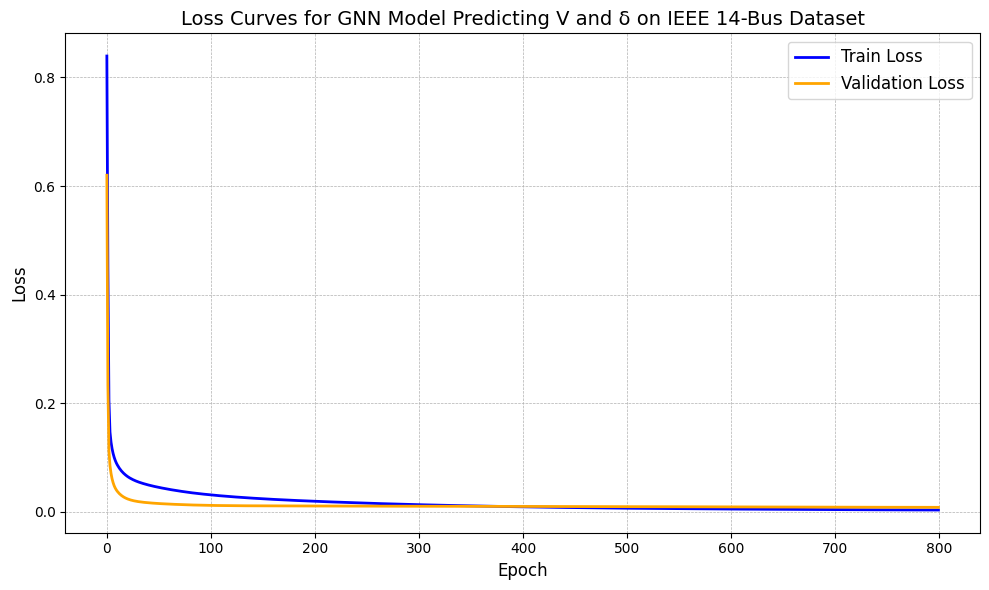


Figure saved as '[14 bus] Loss Curves.png'!
Last epoch: 800, Train loss: 0.0032571, Val loss: 0.0082114
Best epoch: 800, Best Train loss: 0.0032571, Best Val loss: 0.0082114


<Figure size 640x480 with 0 Axes>

In [82]:
import matplotlib.pyplot as plt

# Plot the training and validation loss
plt.figure(figsize=(10, 6))

plt.title(f'Loss Curves for GNN Model Predicting V and δ on IEEE {n_bus}-Bus Dataset', fontsize=14)
plt.plot(train_loss_list, label="Train Loss", color='blue', linewidth=2)
plt.plot(val_loss_list, label="Validation Loss", color='orange', linewidth=2)
#plt.yscale('log')  # Use logarithmic scale for better visualization
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(loc='best', fontsize=12)
plt.tight_layout()
plt.show()

# Save the figure
figure_filename = f"[{n_bus} bus] Loss Curves.png"
plt.savefig(figure_filename, dpi=300)
print(f"\nFigure saved as '{figure_filename}'!")

# Print final and best losses
print(f"Last epoch: {epoch + 1}, Train loss: {train_loss:.7f}, Val loss: {val_loss:.7f}")
print(f"Best epoch: {best_epoch + 1}, Best Train loss: {best_train_loss:.7f}, Best Val loss: {best_val_loss:.7f}")

# **Model Evaluation**

In [61]:
print(y_val_targets.shape)
print(y_val_predictions[0].shape)

torch.Size([2000, 30, 2])
torch.Size([30, 2])


In [83]:
import torch
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd

# Function to calculate regression metrics
def evaluate_regression_metrics(y_true, y_pred):
    # Denormalize the outputs
    y_true = denormalize_output(y_true, y_val_mean, y_val_std)
    y_pred = denormalize_output(y_pred, y_val_mean, y_val_std)

    # Convert to numpy arrays
    y_true = y_true.detach().cpu().numpy()
    y_pred = y_pred.detach().cpu().numpy()

    # Calculate metrics
    mse = mean_squared_error(y_true.reshape(-1, 2), y_pred.reshape(-1, 2))
    rmse = np.sqrt(mse)
    nrmse = rmse / np.std(y_true)
    mae = mean_absolute_error(y_true.reshape(-1, 2), y_pred.reshape(-1, 2))
    r2 = r2_score(y_true.reshape(-1, 2), y_pred.reshape(-1, 2))

    # Print metrics
    print(f"Mean Squared Error (MSE): {mse:.6f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")
    print(f"Normalized RMSE (NRMSE): {nrmse:.6f}")
    print(f"Mean Absolute Error (MAE): {mae:.6f}")
    print(f"R^2 Score: {r2:.6f}")

    return mse, rmse, nrmse, mae, r2

# Evaluation after training
model.eval()
y_val_predictions = []

# Collect all predictions and ground truth for the validation set
with torch.no_grad():
    for batch in val_loader:
        # Forward pass for validation
        y_val_pred = model(batch)

        # Skip empty batches
        if y_val_pred.size(0) == 0:
            continue

        # Reshape predictions based on the actual size
        y_val_pred = y_val_pred.view(-1, n_bus, 2)
        y_val_predictions.append(y_val_pred)

# Stack predictions and targets with the shape [n_samples, n_bus, 2]
y_val_predictions = torch.cat(y_val_predictions, dim=0)
y_val_targets = torch.cat([batch.y.view(-1, n_bus, 2) for batch in val_loader], dim=0)

# Calculate and print regression metrics
mse, rmse, nrmse, mae, r2 = evaluate_regression_metrics(y_val_targets, y_val_predictions)

# Save the metrics to a dictionary for later comparison
metrics = {
    'MSE': mse,
    'RMSE': rmse,
    'NRMSE': nrmse,
    'MAE': mae,
    'R2': r2
}

# Save the metrics to a CSV file
metrics_df = pd.DataFrame([metrics])

# Save the metrics to the CSV file
metrics_filename = f"[{n_bus} bus] Validation Metrics.csv"
metrics_df.to_csv(metrics_filename, index=False)
print(f"\nMetrics saved to '{metrics_filename}'.")


Mean Squared Error (MSE): 0.008211
Root Mean Squared Error (RMSE): 0.090617
Normalized RMSE (NRMSE): 0.012362
Mean Absolute Error (MAE): 0.046869
R^2 Score: 0.996813

Metrics saved to '[14 bus] Validation Metrics.csv'.


# **Single datapoint evaluation**

In [84]:
# Set model to evaluation mode
model.eval()

# Device configuration (ensure compatibility)
device = next(model.parameters()).device

# Function for single datapoint evaluation
def evaluate_single_datapoint(data, y_mean, y_std, y_raw):
    # Move the data to the correct device
    data = data.to(device)

    # Forward pass
    y_pred = model(data)

    # Handle dimensions based on whether the input is batched or not
    if y_pred.dim() == 1:
        # Single datapoint scenario (batch size = 1)
        y_pred = y_pred.view(n_bus, 2)
        data_y = data.y.view(n_bus, 2)
    else:
        # Batched scenario (consistent with batch size handling)
        batch_size = data.y.size(0) // n_bus
        y_pred = y_pred.view(batch_size, n_bus, 2)
        data_y = data.y.view(batch_size, n_bus, 2)

    # Expand y_mean and y_std to match the batch size for denormalization
    y_mean_expanded = y_mean.repeat(batch_size, 1)
    y_std_expanded = y_std.repeat(batch_size, 1)

    # Denormalize the prediction and the ground truth
    y_pred_denorm = denormalize_output(y_pred, y_mean_expanded, y_std_expanded)
    y_target_denorm = denormalize_output(data_y, y_mean_expanded, y_std_expanded)

    # Compute loss
    loss = MSE(y_pred_denorm, y_target_denorm)

    # Print ground truth and prediction
    print("Ground-truth:", y_raw.detach().cpu().numpy())
    print("Prediction:", y_pred_denorm.detach().cpu().numpy())
    print(f"Loss (MSE): {loss:.7f}")

    return loss

# Evaluate on a single training datapoint
print("\nEvaluation on a single training datapoint:")
train_loader_single = DataLoader(train_data_list, batch_size=1, shuffle=False)
train_loss_1 = evaluate_single_datapoint(
    next(iter(train_loader_single)), y_val_mean, y_val_std, y_raw_train[0]
)

# Evaluate on a single validation datapoint
print("\nEvaluation on a single validation datapoint:")
val_loader_single = DataLoader(val_data_list, batch_size=1, shuffle=False)
val_loss_1 = evaluate_single_datapoint(
    next(iter(val_loader_single)), y_val_mean, y_val_std, y_raw_val[0]
)



Evaluation on a single training datapoint:
Ground-truth: [[  1.06      0.     ]
 [  1.045    -5.31568]
 [  1.01    -13.48284]
 [  1.01752 -10.60181]
 [  1.01947  -9.02479]
 [  1.07    -14.16715]
 [  1.05885 -13.0817 ]
 [  1.09    -13.0817 ]
 [  1.04986 -14.37424]
 [  1.04528 -14.46199]
 [  1.0535  -14.42769]
 [  1.05376 -15.15695]
 [  1.04959 -15.12631]
 [  1.02883 -15.77473]]
Prediction: [[[  1.06013   0.00029]
  [  1.04491  -5.25713]
  [  1.00965 -13.17253]
  [  1.01739 -10.52143]
  [  1.01928  -8.9801 ]
  [  1.06962 -14.10181]
  [  1.0605  -12.96308]
  [  1.09007 -12.9708 ]
  [  1.05246 -14.28261]
  [  1.04797 -14.3818 ]
  [  1.05606 -14.38525]
  [  1.05497 -15.04838]
  [  1.05004 -15.06011]
  [  1.03277 -15.84725]]]
Loss (MSE): 0.0052611

Evaluation on a single validation datapoint:
Ground-truth: [[  1.06      0.     ]
 [  1.045    -3.95881]
 [  1.01    -11.02136]
 [  1.02143  -8.44376]
 [  1.02303  -7.14635]
 [  1.07    -11.76542]
 [  1.0625  -10.98824]
 [  1.09    -10.98824]
 [ 

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


# **Testing on Multiple Datasets**

Loading the Best Model

In [85]:
best_model = My_GNN_GNN_NN(n_bus, feat_in, feat_size1, feat_size2, hidden_size1, output_size)

# Load the saved state dictionary
model_filename = f"[{n_bus} bus] Best_GNN_GNN_NN_model.pt"
state_dict = torch.load(model_filename)
print(f"Loaded model weights from '{model_filename}'.")

best_model.load_state_dict(state_dict, strict=False)

# Set the model to evaluation mode
best_model.eval()

Loaded model weights from '[14 bus] Best_GNN_GNN_NN_model.pt'.


<ipython-input-85-d8ce72a5f2bc>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_filename)


My_GNN_GNN_NN(
  (conv1): GCNConv(7, 12)
  (conv2): GCNConv(12, 12)
  (lin1): Linear(in_features=168, out_features=128, bias=True)
  (lin2): Linear(in_features=128, out_features=28, bias=True)
  (dropout): Dropout(p=0, inplace=False)
)

# **NRMSE Function**

In [73]:
def NRMSE(yhat, y):
    rmse = torch.sqrt(torch.mean((yhat - y) ** 2))
    nrmse = rmse / torch.std(y)
    return nrmse

# **Test Dataset Evaluation Loop**

In [86]:
import torch

test_loss_list = []

for i in range(10):
    # Load the test dataset
    dataset = pd.read_excel(f'/content/GNN-OptimalPowerFlow/Datasets/14Bus/PF_Dataset_{i + 1}.xlsx').values
    #dataset = pd.read_excel(f'/content/GNN-OptimalPowerFlow/Datasets/30Bus/PF_Dataset_{i + 1}.xlsx').values
    #dataset = pd.read_excel(f'/content/GNN-OptimalPowerFlow/Datasets/57Bus/PF_Dataset_{i + 1}.xlsx').values

    # Use 20% of the test dataset
    test_dataset = slice_dataset(dataset, 20)
    x_raw_test, y_raw_test = make_dataset(test_dataset, n_bus)
    x_norm_test, y_norm_test, y_test_mean, y_test_std, _, _ = normalize_dataset(x_raw_test, y_raw_test)

    # target statistics (V and δ)
    y_test_mean_targets = y_test_mean[:, :2]
    y_test_std_targets = y_test_std[:, :2]

    # Prepare the test data loader
    data_test_list = [Data(x=x, y=y, edge_index=edge_index) for x, y in zip(x_norm_test, y_norm_test)]
    test_loader = DataLoader(data_test_list, batch_size=16)

    # Initialize predictions
    yhat = torch.empty(0, n_bus, 2).to(device)

    # Collect predictions from the model
    for batch in test_loader:
        batch = batch.to(device)
        y_pred = best_model(batch)

        # Get the size of y_pred and reshape directly
        total_predictions = y_pred.size(0)
        if total_predictions == 0:
            print("Warning: Empty batch encountered, skipping.")
            continue

        # Reshape y_pred to [batch_size, n_bus, 2]
        y_pred = y_pred.view(-1, n_bus, 2)
        yhat = torch.cat((yhat, y_pred), dim=0)

    # Ensure yhat is not empty
    if yhat.size(0) == 0:
        print("Error: No predictions collected. Please check the test data and model.")
        continue

    # Denormalize predictions and ground truth
    yhat_denorm = denormalize_output(yhat, y_test_mean_targets.repeat(yhat.size(0), 1, 1), y_test_std_targets.repeat(yhat.size(0), 1, 1))
    y_raw_test_denorm = denormalize_output(y_norm_test[:, :, :2], y_test_mean_targets, y_test_std_targets)

    # Calculate NRMSE for the test dataset
    try:
        test_loss_NRMSE = NRMSE(yhat_denorm, y_raw_test_denorm)
    except RuntimeError as e:
        print(f"Error in NRMSE calculation: {e}")
        continue

    print(f"Dataset {i + 1} | Test loss (NRMSE): {test_loss_NRMSE:.7f}")
    test_loss_list.append(test_loss_NRMSE)

# Print the summary of test losses
print("Test Losses for All Datasets:", test_loss_list)


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 1 | Test loss (NRMSE): 0.3730086


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 2 | Test loss (NRMSE): 0.3775059


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 3 | Test loss (NRMSE): 0.3727054


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 4 | Test loss (NRMSE): 0.3739252


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 5 | Test loss (NRMSE): 0.3742661


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 6 | Test loss (NRMSE): 0.3727652


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 7 | Test loss (NRMSE): 0.3751188


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 8 | Test loss (NRMSE): 0.3751141


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 9 | Test loss (NRMSE): 0.3746838
Dataset 10 | Test loss (NRMSE): 0.3732651
Test Losses for All Datasets: [tensor(0.37301, grad_fn=<DivBackward0>), tensor(0.37751, grad_fn=<DivBackward0>), tensor(0.37271, grad_fn=<DivBackward0>), tensor(0.37393, grad_fn=<DivBackward0>), tensor(0.37427, grad_fn=<DivBackward0>), tensor(0.37277, grad_fn=<DivBackward0>), tensor(0.37512, grad_fn=<DivBackward0>), tensor(0.37511, grad_fn=<DivBackward0>), tensor(0.37468, grad_fn=<DivBackward0>), tensor(0.37327, grad_fn=<DivBackward0>)]


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


# **Saving Test Losses**

In [88]:
import pandas as pd
import numpy as np

# Ensure the test_loss_list is converted to a format that can be saved
new_list = []

# Convert each test loss value to a float and detach from the computation graph if needed
for x in test_loss_list:
    if isinstance(x, torch.Tensor):
        new_list.append(x.item())  # Use .item() for scalar tensors
    else:
        new_list.append(float(x))  # Convert to float if it's already a number

# Create a DataFrame from the list
test_loss_df = pd.DataFrame(new_list, columns=["Test Loss"])

# Save the DataFrame to an Excel file
test_loss_filename = f"[{n_bus} bus] Test Losses.xlsx"
test_loss_df.to_excel(test_loss_filename, index=False)
print(f"\nTest loss file saved successfully as '{test_loss_filename}'!")



Test loss file saved successfully as '[14 bus] Test Losses.xlsx'!


# **IEEE 14 Bus DataSet Generation**

Contains 14 buses, 5 generators (including the slack bus), 11 loads, and 20 branches.

Represents a simple transmission network, ideal for educational purposes and testing basic load flow algorithms.


In [ ]:
pip install pandapower

In [ ]:
import pandapower as pp
import pandapower.networks as nw
import pandas as pd
import random
import os

# Create the output folder
output_folder = "datasets_14Bus"
os.makedirs(output_folder, exist_ok=True)

# Create the 14-bus test system using pandapower
net = nw.case14()

# Number of datasets and samples per dataset
num_datasets = 10
samples_per_dataset = 2000
variation_range = 0.4  # ±40% random load variation

# columns for the output Excel file
bus_ids = net.bus.index
columns = []

# column names based on dataset format
for bus in bus_ids:
    columns.extend([f"P_{bus + 1} (PQ)", f"Q_{bus + 1} (PQ)", f"V_{bus + 1}", f"d_{bus + 1}"])

# Store original load values for resetting
original_p_values = net.load['p_mw'].copy()
original_q_values = net.load['q_mvar'].copy()

# Generate the datasets
for dataset_n in range(1, num_datasets + 1):
    print(f"Generating dataset {dataset_n}...")

    data = []

    # initial power flow to stabilize the network
    #try:
    #    pp.runpp(net, algorithm='nr', max_iteration=20)
    #except pp.LoadflowNotConverged:
    #    print(f"Initial load flow did not converge for dataset {dataset_n}, skipping this dataset.")
    #    continue

    for sample in range(1, samples_per_dataset + 1):
        # Reset the load values to the original values
        net.load['p_mw'] = original_p_values
        net.load['q_mvar'] = original_q_values

        # Apply random variation based on the original values
        for load in net.load.index:
            net.load.at[load, 'p_mw'] = original_p_values[load] * (1 + random.uniform(-variation_range, variation_range))
            net.load.at[load, 'q_mvar'] = original_q_values[load] * (1 + random.uniform(-variation_range, variation_range))

        # Run AC power flow with Newton-Raphson algorithm
        try:
            pp.runpp(net, algorithm='nr', max_iteration=20)
        except pp.LoadflowNotConverged:
            print(f"Load flow did not converge for sample {sample} in dataset {dataset_n}, skipping this sample.")
            continue

        # Collect data for the current sample
        row = []

        for bus in bus_ids:
            # Extract P and Q values for the bus (PQ buses only)
            if bus in net.load['bus'].values:
                p_load = net.res_load.loc[net.load[net.load['bus'] == bus].index, 'p_mw'].sum()
                q_load = net.res_load.loc[net.load[net.load['bus'] == bus].index, 'q_mvar'].sum()
            else:
                p_load, q_load = 0, 0

            # Extract V (voltage magnitude) and d (voltage angle)
            v_mag = net.res_bus.at[bus, 'vm_pu']
            v_ang = net.res_bus.at[bus, 'va_degree']

            # Append data to the row in the specified format
            row.extend([p_load, q_load, v_mag, v_ang])

        # Add the row to the dataset
        data.append(row)

    # Create a DataFrame and add headers in the requested format
    df = pd.DataFrame(data, columns=columns)

    df.insert(0, "Data", [f"Data {i + 1}" for i in range(len(df))])
    df.insert(0, "Dataset", [f"PF Dataset_{dataset_n}"] + [""] * (len(df) - 1))

    # Save the DataFrame to Excel
    output_filename = os.path.join(output_folder, f"PF_Dataset_{dataset_n}.xlsx")
    df.to_excel(output_filename, index=False)
    print(f"Dataset {dataset_n} saved to {output_filename}")

print("All datasets generated successfully.")


 **14 Bus Generator Limits**

 Generated Active and Reactive Power (P and Q) should be bounded by their maximum and minimum capability for each bus.

 Otherwise the OPF will not converge for the network.

In [ ]:
# Import pandas for cleaner output (optional)
import pandas as pd

# generator bus information
gen_buses = net.gen['bus'].values  # The bus indices with generators
p_gen = net.res_gen['p_mw'].values
q_gen = net.res_gen['q_mvar'].values

# detailed information for each generator
print("Generator Information:")
for i, bus in enumerate(gen_buses):
    p_max = net.gen.at[i, 'max_p_mw'] if 'max_p_mw' in net.gen.columns else "N/A"
    q_max = net.gen.at[i, 'max_q_mvar'] if 'max_q_mvar' in net.gen.columns else "N/A"
    print(f"Bus {bus} | Active Power (P_gen): {p_gen[i]:.2f} MW | Reactive Power (Q_gen): {q_gen[i]:.2f} MVar | P_max: {p_max} MW | Q_max: {q_max} MVar")

print("\nFull Generator DataFrame:")
print(net.gen)


In [ ]:
import pandas as pd

# Initialize lists to track generator outputs
p_gen_list = []
q_gen_list = []

# Run power flow and log generator outputs for multiple test cases
for i in range(10):  # 10 datasets
    try:
        pp.runpp(net, algorithm='nr', max_iteration=20)

        # Get generator active and reactive power outputs
        p_gen = net.res_gen['p_mw'].values
        q_gen = net.res_gen['q_mvar'].values

        # Log the generator outputs
        p_gen_list.append(p_gen)
        q_gen_list.append(q_gen)

        print(f"Test Case {i + 1}:")
        print("Active Power (P_gen):", p_gen)
        print("Reactive Power (Q_gen):", q_gen)
        print("=" * 40)

    except pp.LoadflowNotConverged:
        print(f"Load flow did not converge for Test Case {i + 1}, skipping...")
        continue

# Convert to DataFrame for easier comparison
p_gen_df = pd.DataFrame(p_gen_list, columns=[f"P_gen_{i}" for i in range(len(p_gen))])
q_gen_df = pd.DataFrame(q_gen_list, columns=[f"Q_gen_{i}" for i in range(len(q_gen))])

# Save the results to Excel for further analysis
p_gen_df.to_excel("P_gen_changes.xlsx", index=False)
q_gen_df.to_excel("Q_gen_changes.xlsx", index=False)

print("Generator outputs logged and saved to 'P_gen_changes.xlsx' and 'Q_gen_changes.xlsx'.")


# **IEEE 30 Bus DataSet Generation**

It Contains 30 buses, 6 generators, 21 loads, and 41 branches.

A classic test case for load flow and optimal power flow (OPF) studies.


In [ ]:
pip install pandapower

In [ ]:
import pandapower as pp
import pandapower.networks as nw
import pandas as pd
import random
import os

# Create the output folder
output_folder = "datasets_30Bus"
os.makedirs(output_folder, exist_ok=True)

# Create the 30-bus test system using pandapower
net = nw.case30()

# Number of datasets and samples per dataset
num_datasets = 10
samples_per_dataset = 2000
variation_range = 0.4  # ±40% random load variation

# columns for the output Excel file
bus_ids = net.bus.index
columns = []

# column names based on dataset format
for bus in bus_ids:
    columns.extend([f"P_{bus + 1} (PQ)", f"Q_{bus + 1} (PQ)", f"V_{bus + 1}", f"d_{bus + 1}"])

# Store original load values for resetting
original_p_values = net.load['p_mw'].copy()
original_q_values = net.load['q_mvar'].copy()

# Generate the datasets
for dataset_n in range(1, num_datasets + 1):
    print(f"Generating dataset {dataset_n}...")

    data = []

    # initial power flow to stabilize the network
    #try:
    #    pp.runpp(net, algorithm='nr', max_iteration=20)
    #except pp.LoadflowNotConverged:
    #    print(f"Initial load flow did not converge for dataset {dataset_n}, skipping this dataset.")
    #    continue

    for sample in range(1, samples_per_dataset + 1):
        # Reset the load values to the original values
        net.load['p_mw'] = original_p_values
        net.load['q_mvar'] = original_q_values

        # Apply random variation based on the original values
        for load in net.load.index:
            net.load.at[load, 'p_mw'] = original_p_values[load] * (1 + random.uniform(-variation_range, variation_range))
            net.load.at[load, 'q_mvar'] = original_q_values[load] * (1 + random.uniform(-variation_range, variation_range))

        # Run AC power flow with Newton-Raphson algorithm
        try:
            pp.runpp(net, algorithm='nr', max_iteration=20)
        except pp.LoadflowNotConverged:
            print(f"Load flow did not converge for sample {sample} in dataset {dataset_n}, skipping this sample.")
            continue

        # Collect data for the current sample
        row = []

        for bus in bus_ids:
            # Extract P and Q values for the bus (PQ buses only)
            if bus in net.load['bus'].values:
                p_load = net.res_load.loc[net.load[net.load['bus'] == bus].index, 'p_mw'].sum()
                q_load = net.res_load.loc[net.load[net.load['bus'] == bus].index, 'q_mvar'].sum()
            else:
                p_load, q_load = 0, 0

            # Extract V (voltage magnitude) and d (voltage angle)
            v_mag = net.res_bus.at[bus, 'vm_pu']
            v_ang = net.res_bus.at[bus, 'va_degree']

            # Append data to the row in the specified format
            row.extend([p_load, q_load, v_mag, v_ang])

        # Add the row to the dataset
        data.append(row)

    # Create a DataFrame and add headers in the requested format
    df = pd.DataFrame(data, columns=columns)

    df.insert(0, "Data", [f"Data {i + 1}" for i in range(len(df))])
    df.insert(0, "Dataset", [f"PF Dataset_{dataset_n}"] + [""] * (len(df) - 1))

    # Save the DataFrame to Excel
    output_filename = os.path.join(output_folder, f"PF_Dataset_{dataset_n}.xlsx")
    df.to_excel(output_filename, index=False)
    print(f"Dataset {dataset_n} saved to {output_filename}")

print("All datasets generated successfully.")


Generating dataset 1...
Dataset 1 saved to datasets/PF_Dataset_1.xlsx
Generating dataset 2...
Dataset 2 saved to datasets/PF_Dataset_2.xlsx
Generating dataset 3...
Dataset 3 saved to datasets/PF_Dataset_3.xlsx
Generating dataset 4...
Dataset 4 saved to datasets/PF_Dataset_4.xlsx
Generating dataset 5...
Dataset 5 saved to datasets/PF_Dataset_5.xlsx
Generating dataset 6...
Dataset 6 saved to datasets/PF_Dataset_6.xlsx
Generating dataset 7...
Dataset 7 saved to datasets/PF_Dataset_7.xlsx
Generating dataset 8...
Dataset 8 saved to datasets/PF_Dataset_8.xlsx
Generating dataset 9...
Dataset 9 saved to datasets/PF_Dataset_9.xlsx
Generating dataset 10...
Dataset 10 saved to datasets/PF_Dataset_10.xlsx
All datasets generated successfully.


 **30 Bus Generator Limits**

 Generated Active and Reactive Power (P and Q) should be bounded by their maximum and minimum capability for each bus.

 Otherwise the OPF will not converge for the network.

In [ ]:
# Import pandas for cleaner output (optional)
import pandas as pd

# generator bus information
gen_buses = net.gen['bus'].values  # The bus indices with generators
p_gen = net.res_gen['p_mw'].values
q_gen = net.res_gen['q_mvar'].values

# detailed information for each generator
print("Generator Information:")
for i, bus in enumerate(gen_buses):
    p_max = net.gen.at[i, 'max_p_mw'] if 'max_p_mw' in net.gen.columns else "N/A"
    q_max = net.gen.at[i, 'max_q_mvar'] if 'max_q_mvar' in net.gen.columns else "N/A"
    print(f"Bus {bus} | Active Power (P_gen): {p_gen[i]:.2f} MW | Reactive Power (Q_gen): {q_gen[i]:.2f} MVar | P_max: {p_max} MW | Q_max: {q_max} MVar")

print("\nFull Generator DataFrame:")
print(net.gen)


Generator Information:
Bus 1 | Active Power (P_gen): 60.97 MW | Reactive Power (Q_gen): 37.38 MVar | P_max: 80.0 MW | Q_max: 60.0 MVar
Bus 21 | Active Power (P_gen): 21.59 MW | Reactive Power (Q_gen): 40.45 MVar | P_max: 50.0 MW | Q_max: 62.5 MVar
Bus 26 | Active Power (P_gen): 26.91 MW | Reactive Power (Q_gen): 11.79 MVar | P_max: 55.0 MW | Q_max: 48.7 MVar
Bus 22 | Active Power (P_gen): 19.20 MW | Reactive Power (Q_gen): 7.34 MVar | P_max: 30.0 MW | Q_max: 40.0 MVar
Bus 12 | Active Power (P_gen): 37.00 MW | Reactive Power (Q_gen): 10.96 MVar | P_max: 40.0 MW | Q_max: 44.7 MVar

Full Generator DataFrame:
   name  bus   p_mw  vm_pu  sn_mva  min_q_mvar  max_q_mvar  scaling  slack  \
0  None    1  60.97    1.0     NaN       -20.0        60.0      1.0  False   
1  None   21  21.59    1.0     NaN       -15.0        62.5      1.0  False   
2  None   26  26.91    1.0     NaN       -15.0        48.7      1.0  False   
3  None   22  19.20    1.0     NaN       -10.0        40.0      1.0  False 

In [ ]:
import pandas as pd

# Initialize lists to track generator outputs
p_gen_list = []
q_gen_list = []

# Run power flow and log generator outputs for multiple test cases
for i in range(10):  # 10 datasets
    try:
        pp.runpp(net, algorithm='nr', max_iteration=20)

        # Get generator active and reactive power outputs
        p_gen = net.res_gen['p_mw'].values
        q_gen = net.res_gen['q_mvar'].values

        # Log the generator outputs
        p_gen_list.append(p_gen)
        q_gen_list.append(q_gen)

        print(f"Test Case {i + 1}:")
        print("Active Power (P_gen):", p_gen)
        print("Reactive Power (Q_gen):", q_gen)
        print("=" * 40)

    except pp.LoadflowNotConverged:
        print(f"Load flow did not converge for Test Case {i + 1}, skipping...")
        continue

# Convert to DataFrame for easier comparison
p_gen_df = pd.DataFrame(p_gen_list, columns=[f"P_gen_{i}" for i in range(len(p_gen))])
q_gen_df = pd.DataFrame(q_gen_list, columns=[f"Q_gen_{i}" for i in range(len(q_gen))])

# Save the results to Excel for further analysis
p_gen_df.to_excel("P_gen_changes.xlsx", index=False)
q_gen_df.to_excel("Q_gen_changes.xlsx", index=False)

print("Generator outputs logged and saved to 'P_gen_changes.xlsx' and 'Q_gen_changes.xlsx'.")


Test Case 1:
Active Power (P_gen): [60.97 21.59 26.91 19.2  37.  ]
Reactive Power (Q_gen): [37.38115789 40.44738087 11.79165197  7.33633467 10.95915525]
Test Case 2:
Active Power (P_gen): [60.97 21.59 26.91 19.2  37.  ]
Reactive Power (Q_gen): [37.38115789 40.44738087 11.79165197  7.33633467 10.95915525]
Test Case 3:
Active Power (P_gen): [60.97 21.59 26.91 19.2  37.  ]
Reactive Power (Q_gen): [37.38115789 40.44738087 11.79165197  7.33633467 10.95915525]
Test Case 4:
Active Power (P_gen): [60.97 21.59 26.91 19.2  37.  ]
Reactive Power (Q_gen): [37.38115789 40.44738087 11.79165197  7.33633467 10.95915525]
Test Case 5:
Active Power (P_gen): [60.97 21.59 26.91 19.2  37.  ]
Reactive Power (Q_gen): [37.38115789 40.44738087 11.79165197  7.33633467 10.95915525]
Test Case 6:
Active Power (P_gen): [60.97 21.59 26.91 19.2  37.  ]
Reactive Power (Q_gen): [37.38115789 40.44738087 11.79165197  7.33633467 10.95915525]
Test Case 7:
Active Power (P_gen): [60.97 21.59 26.91 19.2  37.  ]
Reactive Power 

# **IEEE 57 Bus DataSet Generation**

Contains 57 buses, 7 generators, 42 loads, and 80 branches.

Commonly used for testing load flow and contingency analysis.

In [ ]:
pip install pandapower

In [ ]:
import pandapower as pp
import pandapower.networks as nw
import pandas as pd
import random
import os

# Create the output folder
output_folder = "datasets_57Bus"
os.makedirs(output_folder, exist_ok=True)

# Load the 57-bus test system using pandapower
net = nw.case57()

# Number of datasets and samples per dataset
num_datasets = 10
samples_per_dataset = 2000
variation_range = 0.4  # ±40% random load variation

# Define the columns for the output Excel file
bus_ids = net.bus.index
columns = []

# Create column names based on dataset format
for bus in bus_ids:
    columns.extend([f"P_{bus + 1} (PQ)", f"Q_{bus + 1} (PQ)", f"V_{bus + 1}", f"d_{bus + 1}"])

# Store original load values for resetting
original_p_values = net.load['p_mw'].copy()
original_q_values = net.load['q_mvar'].copy()

# Generate the datasets
for dataset_n in range(1, num_datasets + 1):
    print(f"Generating dataset {dataset_n}...")

    data = []

    for sample in range(1, samples_per_dataset + 1):
        # Reset the load values to the original values
        net.load['p_mw'] = original_p_values
        net.load['q_mvar'] = original_q_values

        # Apply random variation based on the original values
        for load in net.load.index:
            net.load.at[load, 'p_mw'] = original_p_values[load] * (1 + random.uniform(-variation_range, variation_range))
            net.load.at[load, 'q_mvar'] = original_q_values[load] * (1 + random.uniform(-variation_range, variation_range))

        # Run AC power flow with Newton-Raphson algorithm
        try:
            pp.runpp(net, algorithm='nr', max_iteration=30)
        except pp.LoadflowNotConverged:
            print(f"Load flow did not converge for sample {sample} in dataset {dataset_n}, skipping this sample.")
            continue

        # Collect data for the current sample
        row = []

        for bus in bus_ids:
            # Extract P and Q values for the bus (PQ buses only)
            if bus in net.load['bus'].values:
                p_load = net.res_load.loc[net.load[net.load['bus'] == bus].index, 'p_mw'].sum()
                q_load = net.res_load.loc[net.load[net.load['bus'] == bus].index, 'q_mvar'].sum()
            else:
                p_load, q_load = 0, 0

            # Extract V (voltage magnitude) and d (voltage angle)
            v_mag = net.res_bus.at[bus, 'vm_pu']
            v_ang = net.res_bus.at[bus, 'va_degree']

            # Append data to the row in the specified format
            row.extend([p_load, q_load, v_mag, v_ang])

        # Add the row to the dataset
        data.append(row)

    # Create a DataFrame and add headers in the requested format
    df = pd.DataFrame(data, columns=columns)
    df.insert(0, "Data", [f"Data {i + 1}" for i in range(len(df))])
    df.insert(0, "Dataset", [f"PF Dataset_{dataset_n}"] + [""] * (len(df) - 1))

    # Save the DataFrame to Excel
    output_filename = os.path.join(output_folder, f"PF_Dataset_{dataset_n}.xlsx")
    df.to_excel(output_filename, index=False)
    print(f"Dataset {dataset_n} saved to {output_filename}")

print("All datasets generated successfully.")


Generating dataset 1...
Dataset 1 saved to datasets_57Bus/PF_Dataset_1.xlsx
Generating dataset 2...
Dataset 2 saved to datasets_57Bus/PF_Dataset_2.xlsx
Generating dataset 3...
Dataset 3 saved to datasets_57Bus/PF_Dataset_3.xlsx
Generating dataset 4...
Dataset 4 saved to datasets_57Bus/PF_Dataset_4.xlsx
Generating dataset 5...
Dataset 5 saved to datasets_57Bus/PF_Dataset_5.xlsx
Generating dataset 6...
Dataset 6 saved to datasets_57Bus/PF_Dataset_6.xlsx
Generating dataset 7...
Dataset 7 saved to datasets_57Bus/PF_Dataset_7.xlsx
Generating dataset 8...
Dataset 8 saved to datasets_57Bus/PF_Dataset_8.xlsx
Generating dataset 9...
Dataset 9 saved to datasets_57Bus/PF_Dataset_9.xlsx
Generating dataset 10...
Dataset 10 saved to datasets_57Bus/PF_Dataset_10.xlsx
All datasets generated successfully.


**57 Bus Generator Limits**

 Generated Active and Reactive Power (P and Q) should be bounded by their maximum and minimum capability for each bus.

 Otherwise the OPF will not converge for the network.

In [ ]:
# Import pandas for cleaner output
import pandas as pd

# generator bus information
gen_buses = net.gen['bus'].values  # The bus indices with generators
p_gen = net.res_gen['p_mw'].values
q_gen = net.res_gen['q_mvar'].values

# detailed information for each generator
print("Generator Information:")
for i, bus in enumerate(gen_buses):
    p_max = net.gen.at[i, 'max_p_mw'] if 'max_p_mw' in net.gen.columns else "N/A"
    q_max = net.gen.at[i, 'max_q_mvar'] if 'max_q_mvar' in net.gen.columns else "N/A"
    print(f"Bus {bus} | Active Power (P_gen): {p_gen[i]:.2f} MW | Reactive Power (Q_gen): {q_gen[i]:.2f} MVar | P_max: {p_max} MW | Q_max: {q_max} MVar")

print("\nFull Generator DataFrame:")
print(net.gen)


Generator Information:
Bus 1 | Active Power (P_gen): 0.00 MW | Reactive Power (Q_gen): 29.40 MVar | P_max: 100.0 MW | Q_max: 50.0 MVar
Bus 2 | Active Power (P_gen): 40.00 MW | Reactive Power (Q_gen): -9.46 MVar | P_max: 140.0 MW | Q_max: 60.0 MVar
Bus 5 | Active Power (P_gen): 0.00 MW | Reactive Power (Q_gen): 12.11 MVar | P_max: 100.0 MW | Q_max: 25.0 MVar
Bus 7 | Active Power (P_gen): 450.00 MW | Reactive Power (Q_gen): 74.54 MVar | P_max: 550.0 MW | Q_max: 200.0 MVar
Bus 8 | Active Power (P_gen): 0.00 MW | Reactive Power (Q_gen): -21.24 MVar | P_max: 100.0 MW | Q_max: 9.0 MVar
Bus 11 | Active Power (P_gen): 310.00 MW | Reactive Power (Q_gen): 109.47 MVar | P_max: 410.0 MW | Q_max: 155.0 MVar

Full Generator DataFrame:
   name  bus   p_mw  vm_pu  sn_mva  min_q_mvar  max_q_mvar  scaling  slack  \
0  None    1    0.0  1.010     NaN       -17.0        50.0      1.0  False   
1  None    2   40.0  0.985     NaN       -10.0        60.0      1.0  False   
2  None    5    0.0  0.980     NaN 

# **Histogram**

Histograms is used to see which architecture has a better and more consistent performance (narrower, left-skewed distribution)

Histograms is used to compare:

1.   Different bus systems (e.g., 14-bus vs. 30-bus vs. 57-bus) using the same GNN architecture.

2.   It can also be used to compare different GNN architectures for a same network to see the effect


**Histogram Goal:**



*   Mean and Median Values: Lower mean and median values indicate better performance.

*   Spread of Distribution: A narrower histogram indicates more consistent performance (less variance).

*   Left-Skewed Distribution: A left-skewed histogram (with most losses near zero) indicates good generalization.



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load the test loss data from each Excel file
bus_14_loss_data = pd.read_excel('[14 bus] Test Losses.xlsx').values.flatten()
bus_30_loss_data = pd.read_excel('[30 bus] Test Losses.xlsx').values.flatten()

# mean and median for each bus system
mean_14 = np.mean(bus_14_loss_data)
median_14 = np.median(bus_14_loss_data)

mean_30 = np.mean(bus_30_loss_data)
median_30 = np.median(bus_30_loss_data)


# Print the statistics
print(f"14-bus system - Mean: {mean_14:.5f}, Median: {median_14:.5f}")
print(f"30-bus system - Mean: {mean_30:.5f}, Median: {median_30:.5f}")

# histogram plotting parameters
kwargs = dict(histtype='stepfilled', alpha=0.5, density=True, bins=20)

# labels for the histograms
label_14 = f"14-bus, Mean: {mean_14:.5f}, Median: {median_14:.5f}"
label_30 = f"30-bus, Mean: {mean_30:.5f}, Median: {median_30:.5f}"

# Plot the histograms
plt.figure(figsize=(10, 6))
plt.hist(bus_14_loss_data, label=label_14, **kwargs)
plt.hist(bus_30_loss_data, label=label_30, **kwargs)

# plot details
plt.title('Comparison of Test Loss Distributions Across Different Test Case Networks')
plt.xlabel('Test Loss (MSE or NRMSE)')
plt.ylabel('Density')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '[14 bus] Test Losses.xlsx'